<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qtensor-vs-other-simulators:-speed" data-toc-modified-id="Qtensor-vs-other-simulators:-speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qtensor vs other simulators: speed</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Plot-comparisons" data-toc-modified-id="Plot-comparisons-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plot comparisons</a></span></li><li><span><a href="#CLI" data-toc-modified-id="CLI-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>CLI</a></span></li></ul></li></ul></div>

# Qtensor vs other simulators: speed

The functions from this notebook are exported and invoken on a remote server.

The data that is generated is transferred back to local machine and plotted here as well

## Generate data

In [2]:
#export
import numpy as np
import qtensor
import quimb
import sys
import pyrofiler.c as profile
#sys.path.pop(2)

from qtensor.tests.qiskit_qaoa_energy import simulate_qiskit_amps
from qtensor.tests.qaoa_quimb import simulate_one_parallel as simulate_quimb_energy
from qtensor.tests.acqdp_qaoa import single_qaoa_query as simulate_acqdp_energy
import matplotlib.pyplot as plt
import time

from cartesian_explorer import Explorer, caches, parallels

/home/danlkv/.local/bin/lib/python3.8/site-packages/numba-0.52.0rc2-py3.8-linux-x86_64.egg/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#export
cache = caches.JobLibCache('../../caex_cache/skylake_speed_comparison')
PAR = True
if PAR:
    parallel = parallels.Ray(processes=50)
    ex = Explorer(cache=cache, parallel=parallel)
else:
    ex = Explorer(cache=cache)

2021-02-22 19:03:43,302	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


In [5]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qtensor.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [6]:
#export
@ex.provider
def simulator(sim):
    simulators = qtensor.tools.benchmarking.simulators
    return {
        'qtensor': simulators.QtensorSimulator,
        'quimb': simulators.QuimbSimulator,
        'acqdp': simulators.AcqdpSimulator,
        'qiskit': simulators.QiskitSimulator
    }[sim]()

@ex.add_function(provides=('opts', 'energy_flops', 'energy_opt_time', 'energy_mem_est', 'energy_tws')
                 , requires=('graph', 'p', 'simulator')
                )
def energy_cost(graph, p,
                simulator,
                sim='qtensor',
                qtn_ordering_algo='greedy',
                qmb_max_repeats=10,
               ):
    kwargs = {}
    if sim=='qtensor':
        kwargs['ordering_algo'] = qtn_ordering_algo
    elif sim=='quimb':
        kwargs['max_repeats'] = qmb_max_repeats
    try:
        opts, ests, time = simulator.optimize_qaoa_energy(graph, p, **kwargs)
    except Exception as e:
        print('error', e)
        return None, None, None, None, None
    flops = [est.flops for est in ests]
    mems = [est.mems for est in ests]
    tws = [est.width for est in ests]
    print(flops)
    return opts, sum(flops), time, max(mems), tws
        

In [7]:
@ex.add_function(provides=('energy_time', 'energy_memory')
                 , requires=('graph', 'p', 'simulator', 'opts')
                )
def energy_cost(graph, p, simulator, opts,
                sim='qtensor',
                qtn_backend='einsum',
               ):
    kwargs = {}
    if sim=='qtensor':
        kwargs['backend'] = qtn_backend
        
    try:
        res, time, memory = simulator.simulate_qaoa_energy(graph, p, opts, **kwargs)
    except Exception as e:
        print('error', e)
        return None, None
    return time, memory

In [8]:
_time = ex.get_variable('energy_time', sim='qiskit', N=10, p=2)
_mem = ex.get_variable('energy_memory', sim='qiskit', N=10, p=2)
print(_time, _mem)

[2048]
0.13049626350402832 2109440


In [10]:
_time, _mem = ex.get_variables(('energy_time', 'energy_memory'), sim='quimb', N=10, p=2)
_tw = ex.get_variable('energy_tws', sim='quimb', N=10, p=2)
print(_time, _mem, _tw)

0.04926156997680664 155648 [7.0, 6.0, 7.0, 7.0, 6.0, 7.0, 8.0, 6.0, 6.0, 6.0, 8.0, 6.0, 7.0, 7.0, 7.0]


## Generate data

In [11]:
#export
def gen_time_data(Ns, ps, **kwargs):
    xar = ex.get_variables_xarray(
        ('energy_flops', 'energy_mem_est', 'energy_opt_time', 'energy_tws',
         'energy_time', 'energy_memory'),
        p=ps,
        N=Ns,
        **kwargs,
    )
    return xar

In [31]:
Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
Ns = Ns[1:8]

ps = [3, 4, 5]
seeds = [10, 11, 12, 13]

In [29]:
xar = gen_time_data(Ns, ps, n_processes=[1],
                    sim=['qiskit', 'acqdp', 'quimb', 'qtensor'],
                    qtn_ordering_algo=['rgreedy_0.02_10'],
                    qmb_max_repeats=[10],
                    qiskit_method=['matrix_product_state'],
                    seed=seeds
                   )
xar

2021-02-22 19:41:53,212	WARNING worker.py:1091 -- A worker died or was killed while executing task 679a90e9f7683e92ffffffff01000000.
2021-02-22 19:42:42,660	WARNING worker.py:1091 -- A worker died or was killed while executing task b4d30f8ae3c870f7ffffffff01000000.
2021-02-22 19:43:17,375	WARNING worker.py:1091 -- A worker died or was killed while executing task ecff0aa3d8b23247ffffffff01000000.
2021-02-22 19:43:27,327	WARNING worker.py:1091 -- A worker died or was killed while executing task 6c76b3d6608a39dfffffffff01000000.
2021-02-22 19:44:02,500	WARNING worker.py:1091 -- A worker died or was killed while executing task 171f5a423b7c2468ffffffff01000000.
2021-02-22 19:44:25,300	WARNING worker.py:1091 -- A worker died or was killed while executing task e5535c4f66060a9affffffff01000000.
2021-02-22 19:44:48,998	WARNING worker.py:1091 -- A worker died or was killed while executing task 679a90e9f7683e92ffffffff01000000.
2021-02-22 19:45:53,517	WARNING worker.py:1091 -- A worker died or wa

WorkerCrashedError: The worker died unexpectedly while executing this task.

## Read data

In [17]:
import xarray

In [ ]:
xar = xarray.load_dataarray('../../../second_try.nc')

## Retreive data from cache

In [37]:
data = ex.map_variables_no_call(
    ('energy_flops', 'energy_mem_est', 'energy_opt_time', 'energy_tws',
     'energy_time', 'energy_memory'),
    p=ps,
    N=Ns,
    n_processes=[1],
    sim=['qiskit', 'acqdp', 'quimb', 'qtensor'],
    qtn_ordering_algo=['rgreedy_0.02_10'],
    qmb_max_repeats=[10],
    qiskit_method=['matrix_product_state'],
    seed=seeds

)

/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [38]:
dims = dict(
    varname=['energy_flops', 'energy_mem_est', 'energy_opt_time', 'energy_tws',
     'energy_time', 'energy_memory'],
    p=ps,
    N=Ns,
    n_processes=[1],
    sim=['qiskit', 'acqdp', 'quimb', 'qtensor'],
    qtn_ordering_algo=['rgreedy_0.02_100'],
    qmb_max_repeats=[100],
    qiskit_method=['matrix_product_state'],
    seed=seeds
)
_dimcount = len(data.shape)
_dimnames = list(dims.keys())
dimvals = {k:dims[k] for k in _dimnames if len(dims[k])>1}

xar = xarray.DataArray(data, dims=list(dimvals.keys()), coords=dimvals)

In [39]:
def plot_xarray(ex, xar, **kwargs):
    dims = {k:xar.coords[k].data for k in xar.dims}
    kwargs = {**kwargs, **dims}
    def safe_sel(*args, **kwargs):
        try:
            return xar.sel(*args, **kwargs).item()
        except Exception:
            return None
    fig = ex.plot(safe_sel, **kwargs)
    return fig

In [44]:
def data_lists_mean(line_data):
    """[
    [
    [[0, 1, 2], None ], [None, None]
    ]
    to [
    [1, None], [None, None]
    ]
    """
    for i, pt in enumerate(line_data):
        line_data[i] = [np.mean(x) if x is not None else None for x in pt]
    return line_data
    
def plot_with_band(x, line_data, **kwargs):
    # for tws
    line_data = data_lists_mean(line_data)
    
    line_data = line_data.astype(np.float64)
    maxs = np.max(line_data, axis=-1)
    mins = np.min(line_data, axis=-1)
    std = np.nanstd(line_data, axis=-1)
    mean = np.nanmean(line_data, axis=-1)
    relstd = (mean-std)/mean
    
    plt.plot(x, mean, '.-', **kwargs)
    fill_kwargs = dict(
        alpha=0.05, color=kwargs.get('color')
    )
    plt.fill_between(x, mean + std, mean - std, **fill_kwargs)
    

/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/ExplorerBasic.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(result_lin).reshape(result_shape)


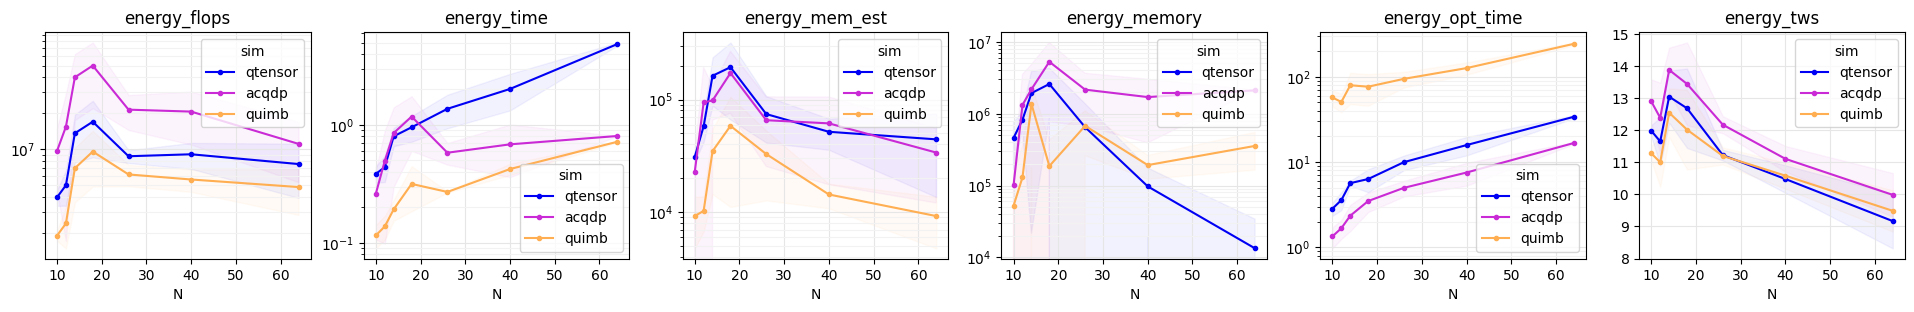

In [49]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

p = 3
fig = plot_xarray(ex, xar_tr.sel(
    varname=['energy_flops','energy_time',
             'energy_mem_est', 'energy_memory', 'energy_opt_time', 'energy_tws']
    #varname=['energy_tws' ]
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=p
), 
            plot_func=plot_with_band,
            distribution_var='seed',
           )

for ax in fig.axes[:5]:
    ax.set_yscale('log')
    
plt.savefig(f'../../../data/figures/speed_comparison_p{p}.pdf')

In [ ]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

fig = plot_xarray(ex, xar_tr.sel(
    varname=['energy_time', 'energy_memory']
    #varname=['energy_tws' ]
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=5
), 
            plot_func=plot_with_band,
            distribution_var='seed',
           )

for ax in fig.axes[:2]:
    ax.set_yscale('log')

## Debugging of quimb

In [11]:
_time = ex.get_variable('energy_time', sim='quimb', N=26, p=4, seed=10)
_mem = ex.get_variable('energy_memory', sim='quimb', N=26, p=4, seed=10)
_time, _mem


[2573704, 28996784, 4806416, 438600, 20240724, 40896744, 87690832, 13073936, 4065040, 13593468, 73468344, 58129880, 40271884, 7538140, 3784352, 1292216, 1603184, 4807884, 3289184, 79664352, 28928080, 197877440, 19876968, 23861040, 10077792, 1156208, 1388248, 15492520, 3887224, 44972704, 20583864, 26652804, 27254632, 21071104, 155199320, 4766040, 53102320, 6368248, 723640]
simulating energy


/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/Explorer.py:220: UserWarning: Persisting input arguments took 2.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  retval = f(**call_kwd)


simulating energy


/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/Explorer.py:220: UserWarning: Persisting input arguments took 2.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  retval = f(**call_kwd)


(12.329769849777222, 279302144)

In [16]:
import autoray

In [17]:
circ = quimb.tensor.circ_qaoa(terms, p, [0.1]*p, [0.2]*p)
def get_lightcone_circ(circ, G, where):
    rho = circ.get_rdm_lightcone_simplified(where, 'ADCRS', 1e-12)
    k_inds = tuple(circ.ket_site_ind(i) for i in where)
    b_inds = tuple(circ.bra_site_ind(i) for i in where)
    G_data = autoray.reshape(G, (2,)*2*len(where))
    output_inds = ()
    TG = quimb.tensor.Tensor(data=G_data, inds=output_inds + b_inds + k_inds)
    rho_G = rho | TG
    return rho_G
    

In [22]:
rho = get_lightcone_circ(circ, ZZ, list(G.edges)[ix])
rho

<TensorNetwork(tensors=217, indices=101)>

In [23]:
opt = cotengra.HyperOptimizer(max_repeats=10)
info_ns_tr = rho.contract(output_inds=(), get='path-info', optimize=info_ns.path)
np.log2(float(info_ns_tr.largest_intermediate))

14.0

Simplify with TG

In [40]:
rho.full_simplify_(seq='D', atol=1e-12, output_inds=())

<TensorNetwork(tensors=215, indices=99)>

In [41]:
info = rho.contract(output_inds=(), get='path-info', optimize=_inf[ix].path)
np.log2(float(info.largest_intermediate))

79.0

In [47]:
def tn2eq(tn):
    i_ix = tuple(t.inds for t in tn)
    total_ix = tuple(quimb.utils.concat(i_ix))
    all_ix = tuple(quimb.utils.oset(total_ix))
    o_ix = tuple(quimb.tensor.tensor_core._gen_output_inds(total_ix))
    eq = quimb.tensor.tensor_core._inds_to_eq(all_ix, i_ix, o_ix)
    return eq

In [12]:
qtensor.tests.qaoa_quimb.simulate_one(graph(26), p=4, max_repeats=10)

(16.312023504735656-6.476326618423887e-16j)

/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/ExplorerBasic.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(result_lin).reshape(result_shape)


TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

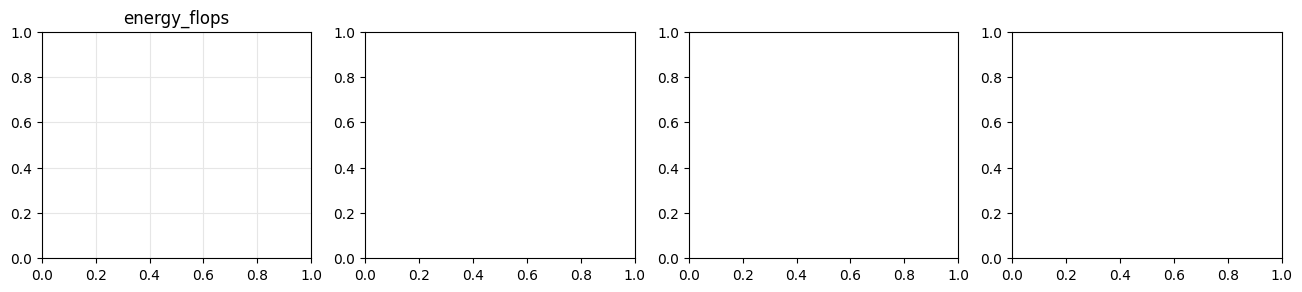

In [113]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')

plot_xarray(ex, xar_tr.sel(
    varname=['energy_flops', 'energy_mem_est', 'energy_tws', 'energy_opt_time']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=3
), 
            distribution_var='seed',
           )

## Plot comparisons


ValueError: cannot reshape array of size 108 into shape (6,6)

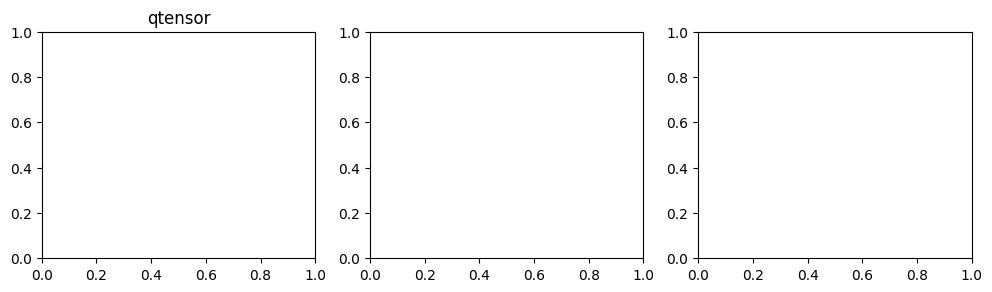

In [32]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N', 'seed')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr.sel(
    varname=['energy_flops', 'energy_mem_est', 'energy_opt_time']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=3
)
                     distr_
                    )
for ax in fig.axes[:]:
    ax.set_yscale('log')


[10, 12, 14, 18, 26, 40, 64, 106] [None None None None None None None None] {'label': 'qiskit', 'color': (0.0, 0.0, 0.9568627450980391, 1.0)}
[10, 12, 14, 18, 26, 40, 64, 106] [None None None None None None None None] {'label': 'acqdp', 'color': (0.5055147058823528, 0.0, 1.0, 1.0)}
[10, 12, 14, 18, 26, 40, 64, 106] [None None None None None None None None] {'label': 'quimb', 'color': (1.0, 0.3364705882352942, 0.6635294117647059, 1.0)}
[10, 12, 14, 18, 26, 40, 64, 106] [None None None None None None None None] {'label': 'qtensor', 'color': (1.0, 0.6815686274509803, 0.31843137254901976, 1.0)}


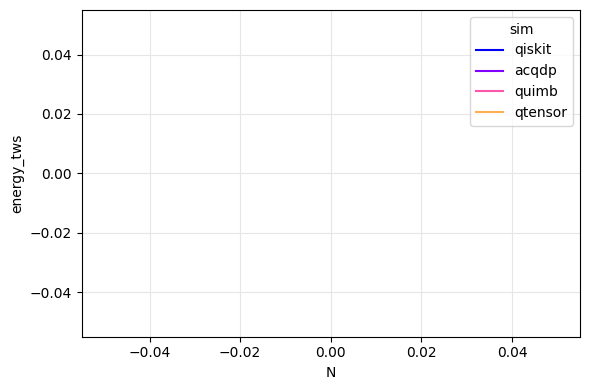

2021-02-14 06:47:36,305	WARNING worker.py:1091 -- A worker died or was killed while executing task 1d1a061f125e8db0ffffffff01000000.


In [75]:
xar_tr = xar.transpose('p', 'varname', 'sim', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})

def pl(x, y, **kwargs):
    try:
        z = [max(i) if i else None for i in y]
        plt.plot(x, z, **kwargs)
    except Exception:
        z = None
    
fig = ex.plot_xarray( xar_tr.sel(
    varname=['energy_tws']
    , sim=['qtensor', 'acqdp', 'quimb']
    , p=4
)
    , plot_func=pl
)



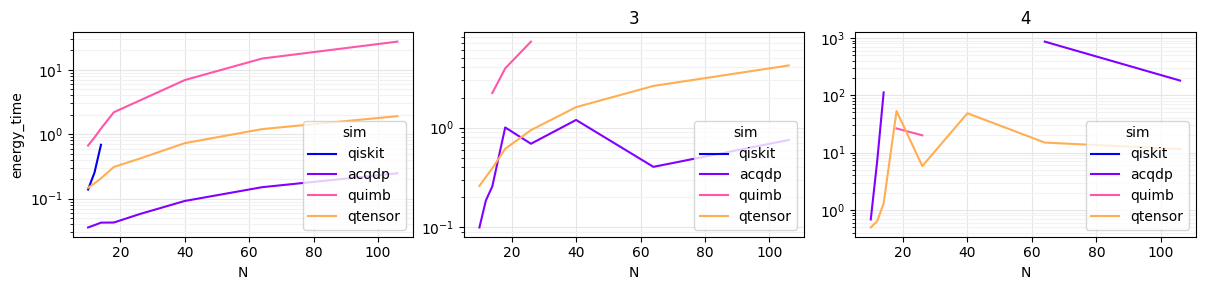

In [27]:
xar_tr = xar.transpose('varname', 'p', 'sim', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr.sel(
    varname=['energy_time']#, 'energy_memory']
    #, p=4
))

for ax in fig.axes:
    ax.set_yscale('log')

In [19]:
    #export
def plot_xar_data(xar_orig):
    xar = xar_orig.transpose('p', 'varname', 'N')
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log', base=2)
    fig = ex.plot_xarray(xar, plot_func=custom_plot)

    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)
    ps = [x.data for x in xar.coords['p']]


    [ax.autoscale() for ax in axes]
    [ax.set_ylabel('Time, sec') for ax in axes]
    [ax.set_title(x) for ax, x in zip(axes, [f"p = {p}" for p in ps])]
    fig.suptitle('Time for single energy query on a single Skylake node', fontfamily='serif', style='italic')
    fig.set_size_inches(10.5, 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])


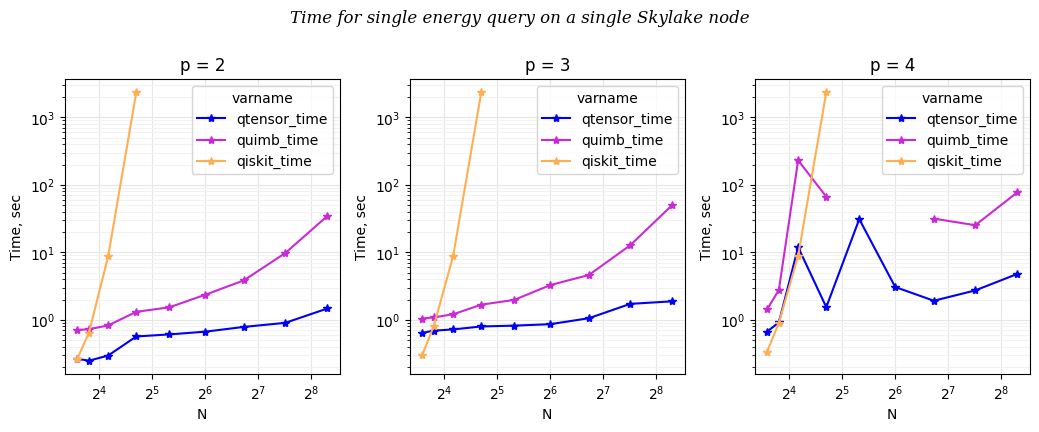

In [21]:
plot_xar_data(xar)

In [20]:
def plot_xar_data_simple(xar_orig):
    xar = xar_orig.sel(p=3)
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log' )
        plt.xticks([10, 20, 50, 100, 200, 500])
    fig = ex.plot_xarray(xar, plot_func=custom_plot)
    from matplotlib.ticker import FormatStrFormatter

    fig.gca().xaxis.set_major_formatter(FormatStrFormatter('%.i'))
    fig.gca().yaxis.set_major_formatter(FormatStrFormatter('%.i'))


    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)


    fig.gca().set_ylabel('Time, sec')
    fig.gca().set_xlabel('Number of qubits')
    fig.suptitle('Time for a quantum circuit simulation', fontfamily='serif', style='italic')
    plt.legend(['Our simulator', 'Caltech simulator', 'IBM simulator'])
    fig.set_size_inches(5., 4.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])

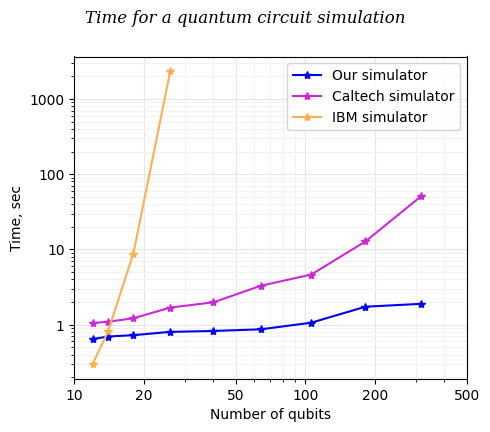

In [32]:
plot_xar_data_simple(xar)
plt.savefig('../../../data/figures/speed_comparison_simple_p3.png')
plt.savefig('../../../data/figures/speed_comparison_simple_p3.pdf')

## CLI

In [49]:
#export
from qtensor_specs import cli, click

In [50]:
#export
@cli.command()
@click.option('--n_len', default=4)
@click.option('--p_len', default=2)
@click.option('-O', '--qtn_ordering_algo', default='greedy')
@click.option('-N', '--n_processes', default=2)
@click.argument('filename')
def time_comparison_xarray(filename, n_len, p_len, **kwargs):
    Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
    Ns = Ns[:n_len]
    ps = [2, 3, 4]
    ps = ps[:p_len]
    kwargs = {k:[v] for k, v in kwargs.items()}
    xar = gen_time_data(Ns, ps, **kwargs)
    xar.to_netcdf(filename)
    

In [62]:
#export
import logging
ql = logging.getLogger('qiskit')
ql.setLevel(logging.ERROR)

In [64]:
Ns = [10, 14]
ps = [2, 3]
xar = gen_time_data(Ns, ps)



_dimcount 3


In [65]:
#hide
#default_exp speed_comparison

from nbdev.export  import *
notebook2script()

Converted QAOA_bench.ipynb.
Converted Speed_comparison.ipynb.
Converted Time_vs_FLOP.ipynb.
Converted index.ipynb.
